# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'

Mounted at /content/drive


In [2]:
from torch.utils.data import random_split, Dataset, DataLoader
import pandas as pd

import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_absolute_error
import torch.nn.utils.prune as prune
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

# File Viewing

In [ ]:
def print_structure(file_name):
    with h5py.File(file_name, 'r') as f:
        f.visititems(print_item)

def print_item(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name, obj.shape, obj.dtype)
    elif isinstance(obj, h5py.Group):
        print(name)

file_name = path + 't.hdf5'
print_structure(file_name)

jet_features (177945, 4) float32
particle_features (177945, 30, 4) float32


In [ ]:
with h5py.File(file_name, 'r') as f:
    jet_features_data = f['jet_features'][:]
    particle_features_data = f['particle_features'][:]

In [ ]:
def explore_hdf5(filename):
    with h5py.File(filename, 'r') as file:
        # Explore the file's datasets
        for name, dataset in file.items():
            print(f"Dataset name: {name}")
            print(f"Shape: {dataset.shape}")
            print(f"Datatype: {dataset.dtype}")
            print(f"Content (first 1 elements): {dataset[:2]}")
            print("------")

        # If you specifically want to see the labels (assuming they are in a dataset named 'labels'):
        if 'labels' in file:
            print(f"Labels: {file['labels'][:]}")

explore_hdf5(file_name)

Dataset name: jet_features
Shape: (177945, 4)
Datatype: float32
Content (first 1 elements): [[ 1.00083856e+03 -1.02152944e+00  1.73566376e+02  3.00000000e+01]
 [ 9.81978027e+02 -1.26148816e-02  1.09439171e+02  3.00000000e+01]]
------
Dataset name: particle_features
Shape: (177945, 30, 4)
Datatype: float32
Content (first 1 elements): [[[-1.53595209e-01  1.56128213e-01  9.74499434e-02  1.00000000e+00]
  [ 3.48459519e-02 -5.12997173e-02  5.63035794e-02  1.00000000e+00]
  [ 3.70894000e-02 -6.32425919e-02  5.48189804e-02  1.00000000e+00]
  [ 5.59603274e-02 -9.16898996e-02  5.38143031e-02  1.00000000e+00]
  [ 2.66186912e-02 -5.69021069e-02  5.33443168e-02  1.00000000e+00]
  [ 6.22004308e-02 -8.14543292e-02  4.65002544e-02  1.00000000e+00]
  [ 1.28914028e-01 -1.95329696e-01  3.87960188e-02  1.00000000e+00]
  [ 4.87124994e-02 -6.40405789e-02  3.82680222e-02  1.00000000e+00]
  [ 3.90293971e-02 -5.20421118e-02  3.79129350e-02  1.00000000e+00]
  [ 5.69136292e-02 -2.26166807e-02  3.51505280e-02  1

In [ ]:
column_names = ['etarel', 'phirel', 'ptrel', 'number of particles']  # adjust accordingly
df_jet_features.columns = column_names
print(df_jet_features.head())

        etarel    phirel       ptrel  mask
0  1068.627197 -0.464242   61.029995  30.0
1   980.443970 -1.335959   82.200760  30.0
2  1129.626831  1.582208   80.016754  30.0
3  1397.575684  0.565535   72.295326  30.0
4  1156.092285  0.042042  125.922127  30.0


# Data Loading

In [3]:
path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'

def load_data_from_h5(filename):
    with h5py.File(filename, 'r') as f:
        #jet_features = f['jet_features'][:, :-1]  # rewrite to consider pt, eta, mass, number of particles accordingly
        particle_features = f['particle_features'][:, :, :-1]  # excluding the mask column
    #return jet_features, particle_features
    return particle_features

def select_top_particles(particle_data, n_particles=10):
    # Original pT values for the first few jets
    #print("Original pT values for the first jet:", particle_data[0, :, 2])

    sorted_indices = np.argsort(particle_data[:,:,2], axis=1)[:,::-1]
    batch_size = particle_data.shape[0]
    range_indices = np.arange(batch_size)[:,np.newaxis]
    top_particle_data = particle_data[range_indices, sorted_indices[:,:n_particles]]

    # Sorted pT values for the first few jets
    #print("Sorted pT values for the first jet:", top_particle_data[0, :, 2])

    return top_particle_data

def compute_mean_std(data):
    means = data.mean(axis=0)
    std_devs = data.std(axis=0)
    return means, std_devs

class ParticlePhysicsDataset(Dataset):
    def __init__(self, jet_features, particle_features, train=True, mean=None, std=None):
        # Reshape and concatenate data
        #jet_data = jet_features.reshape(-1, 3)  # as we have 3 features: pt, eta, mass
        particle_data = select_top_particles(particle_features).reshape(-1, 10*3)  # 10 top particles * 3 features each
        #concatenated_data = np.concatenate((particle_data, jet_data), axis=1)

        # Normalize
        if train:
            self.mean, self.std = compute_mean_std(particle_data)
        else:
            if mean is None or std is None:
                raise ValueError("For test set, mean and std must be provided.")
            self.mean, self.std = mean, std
        self.data = (particle_data - self.mean) / self.std
        self.data = torch.tensor(self.data, dtype=torch.float32)

        # Compute losses
        self.losses = torch.mean(torch.pow(self.data, 2), dim=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.losses[idx]

def load_data_by_filetype(filepaths):
    data_dict = {}
    for filepath in filepaths:
        filetype = filepath.split('/')[-1].split('.')[0]  # Extract the file type (g, q, t, w, z) from the filename
        data_dict[filetype] = load_data_from_h5(filepath)
    return data_dict

# Filepaths for each data type
background_files = [path + fname for fname in ['q.hdf5', 'g.hdf5']]
signal_files = [path + fname for fname in ['t.hdf5', 'w.hdf5', 'z.hdf5']]

# Load data by file type
background_data = load_data_by_filetype(background_files)
signal_data = load_data_by_filetype(signal_files)

# Ensuring 50-50 split from both q and g for training and testing
q_particles = background_data['q']
g_particles = background_data['g']

# Taking half of each background data type for training
train_q = q_particles[:len(q_particles) // 2]
train_g = g_particles[:len(g_particles) // 2]

# And the other half for testing
test_q = q_particles[len(q_particles) // 2:]
test_g = g_particles[len(g_particles) // 2:]

# Combining them together
train_particle = np.vstack([train_q, train_g])
test_particle = np.vstack([test_q, test_g])

# Datasets for training and testing on background data
train_dataset = ParticlePhysicsDataset(None, train_particle)
test_dataset = ParticlePhysicsDataset(None, test_particle, train=False, mean=train_dataset.mean, std=train_dataset.std)

# Datasets for each signal type
signal_datasets = {}
for key, particle in signal_data.items():
    signal_datasets[key] = ParticlePhysicsDataset(None, particle, train=False, mean=train_dataset.mean, std=train_dataset.std)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)  # No need to shuffle test data
t_signal_dataloader = DataLoader(signal_datasets['t'], batch_size=1024, shuffle=False)
w_signal_dataloader = DataLoader(signal_datasets['w'], batch_size=1024, shuffle=False)
z_signal_dataloader = DataLoader(signal_datasets['z'], batch_size=1024, shuffle=False)

In [5]:
def compute_dataloader_mean_std(dataloader):
    # Initialize values for running mean and variance
    running_sum = 0.0
    running_squared_sum = 0.0
    total_samples = 0

    for batch, _ in dataloader:
        # Flatten the data batch as we only want feature-wise mean and std
        flat_batch = batch.view(batch.size(0), -1)

        running_sum += flat_batch.sum(dim=0)
        running_squared_sum += (flat_batch ** 2).sum(dim=0)
        total_samples += flat_batch.size(0)

    feature_means = running_sum / total_samples
    feature_variances = (running_squared_sum / total_samples) - (feature_means ** 2)
    feature_stds = torch.sqrt(feature_variances)

    # Compute overall mean and std
    mean = feature_means.mean().item()
    std = feature_stds.mean().item()
    return mean, std

dataloaders = {
    'train': train_dataloader,
    'test': test_dataloader,
    't_signal': t_signal_dataloader,
    'w_signal': w_signal_dataloader,
    'z_signal': z_signal_dataloader
}

for name, dataloader in dataloaders.items():
    mean, std = compute_dataloader_mean_std(dataloader)
    print(f'{name} - Mean: {mean:.4f}, Std: {std:.4f}')

train - Mean: -0.0000, Std: 1.0000
test - Mean: -0.0011, Std: 1.0012
t_signal - Mean: -0.0071, Std: 1.6625
w_signal - Mean: 0.0571, Std: 1.0863
z_signal - Mean: 0.0507, Std: 1.1863


# Methods and Plotting

In [50]:
# returns tpr value for specific threshold
# signal_losses is a tensor of individual losses for a given signal dataset
def get_tpr(threshold, signal_losses):
    tpr = torch.sum(signal_losses > threshold).float() / len(signal_losses)
    return tpr

# retruns threshold given an fpr
def get_threshold(fpr, background_losses):
    background_losses = background_losses.sort()[0] # Use PyTorch's sort function and pick values
    num_false_pos = int(len(background_losses) * fpr)
    threshold = background_losses[-num_false_pos]
    return threshold

#exponential linespace because we have a large threshold space to cover
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

def batch_MSE(input, output):
    loss = torch.mean(torch.pow(input - output, 2), dim = 1)
    return loss

def get_losses(model, dataloader):
    model.eval()
    criterion = batch_MSE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    with torch.no_grad():
        for data in dataloader:
            data = data.float().to(device)
            outputs = model(data)
            losses = criterion(data, outputs)
            results.append(losses)
    return torch.cat(results, 0)

def print_tprs(background_losses, list_of_signal_losses, signal_labels, fpr = 1e-5):
    threshold = get_threshold(fpr, background_losses)
    for idx, signal_losses in enumerate(list_of_signal_losses):
      tpr = get_tpr(threshold, signal_losses)
      #print(signal_labels[idx], tpr)
      print(f"{signal_labels[idx]} {tpr.item():.7f}")

def get_tpr_for_fpr(background_losses, signal_losses, fpr=1e-5):
    threshold = get_threshold(fpr, background_losses)
    tpr = get_tpr(threshold, signal_losses)
    return tpr.item()

def plot_auc(background_losses, list_of_signal_losses, list_of_signal_labels, num_fprs=100):
    fprs = powspace(1e-5, 1, 5, num_fprs)

    # Dictionary to store the TPR values for each signal at FPR=0.1
    #tpr_at_fpr_0_1 = {}

    for signal_losses, signal_label in zip(list_of_signal_losses, list_of_signal_labels):
        tprs = torch.zeros(num_fprs)
        for fpr_idx, fpr in enumerate(fprs):
            threshold = get_threshold(fpr, background_losses)
            tpr = get_tpr(threshold, signal_losses)
            tprs[fpr_idx] = tpr

        # Store TPR for FPR=0.1
        #tpr_at_fpr_0_1[signal_label] = get_tpr_for_fpr(background_losses, signal_losses, fpr=0.1)

        # Plot curve for the current signal dataset
        plt.plot(fprs, tprs.numpy(), label=f'{signal_label}, AUC: {auc(fprs, tprs.numpy()):.5f}')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")

    plt.legend(loc='center right')

    # # Adjust legend to incorporate the TPR values for FPR of 0.1
    # handles, labels = plt.gca().get_legend_handles_labels()
    # new_labels = [f"{label}, TPR@FPR=0.1: {tpr_at_fpr_0_1[label.split(',')[0]]:.5f}" for label in labels]
    # plt.legend(handles, new_labels, loc='center right')

    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.1, color='red', linestyle='dashed', linewidth=1)  # threshold value for measuring anomaly detection efficiency
    plt.title(r"Particle ($\eta_{\mathrm{rel}}$, $\phi_{\mathrm{rel}}$, $p_{T,\mathrm{rel}}$) ROC")

    plt.show()

def plot_histogram(background_losses, list_of_signal_losses, list_of_signal_labels, bin_size):
    # Make sure the number of signal loss tensors matches the number of labels
    assert len(list_of_signal_losses) == len(list_of_signal_labels), "Mismatch between number of signals and labels"

    # Calculate the total number of events
    total_events = background_losses.size(0) + sum([loss.size(0) for loss in list_of_signal_losses])

    plt.figure(figsize=(10,8))

    # Weights for the background
    background_weights = np.ones_like(background_losses.cpu().numpy()) * background_losses.size(0) / total_events

    plt.hist(background_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label='background', weights=background_weights)

    # Now, iterate through each signal and plot it
    for signal_losses, label in zip(list_of_signal_losses, list_of_signal_labels):
        signal_weights = np.ones_like(signal_losses.cpu().numpy()) * signal_losses.size(0) / total_events
        plt.hist(signal_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label=label, weights=signal_weights)

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("Autoencoder Loss")
    plt.ylabel("Probability (a.u.)")
    plt.title(r"Particle ($\eta_{\mathrm{rel}}$, $\phi_{\mathrm{rel}}$, $p_{T,\mathrm{rel}}$) MSE loss")
    plt.legend()
    plt.show()

In [40]:
bkg_losses = []
for data, loss in test_dataloader:
    bkg_losses.append(loss)
bkg_losses = torch.cat(bkg_losses, 0)

t_signal_losses = []
for data, loss in t_signal_dataloader:
    t_signal_losses.append(loss)
t_signal_losses = torch.cat(t_signal_losses, 0)

w_signal_losses = []
for data, loss in w_signal_dataloader:
    w_signal_losses.append(loss)
w_signal_losses = torch.cat(w_signal_losses, 0)

z_signal_losses = []
for data, loss in z_signal_dataloader:
    z_signal_losses.append(loss)
z_signal_losses = torch.cat(z_signal_losses, 0)

In [41]:
threshold = get_threshold(0.1, bkg_losses)
t_tpr = get_tpr(threshold, t_signal_losses)
w_tpr = get_tpr(threshold, w_signal_losses)
z_tpr = get_tpr(threshold, z_signal_losses)
print(t_tpr, w_tpr, z_tpr)

tensor(0.6507) tensor(0.0348) tensor(0.0584)


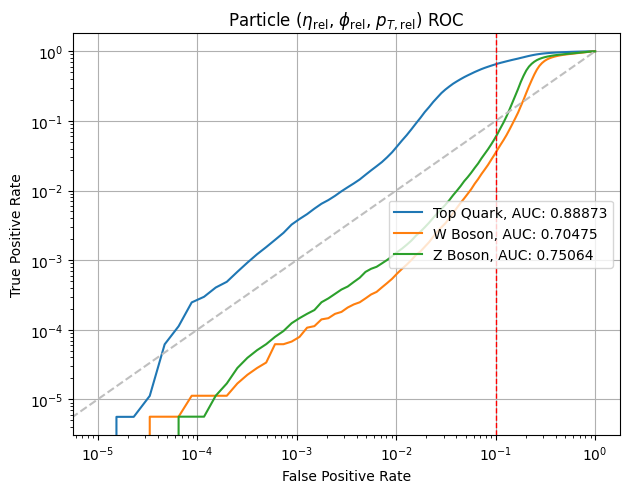

In [51]:
plot_auc(bkg_losses, [t_signal_losses, w_signal_losses, z_signal_losses], ['Top Quark', 'W Boson', 'Z Boson'])

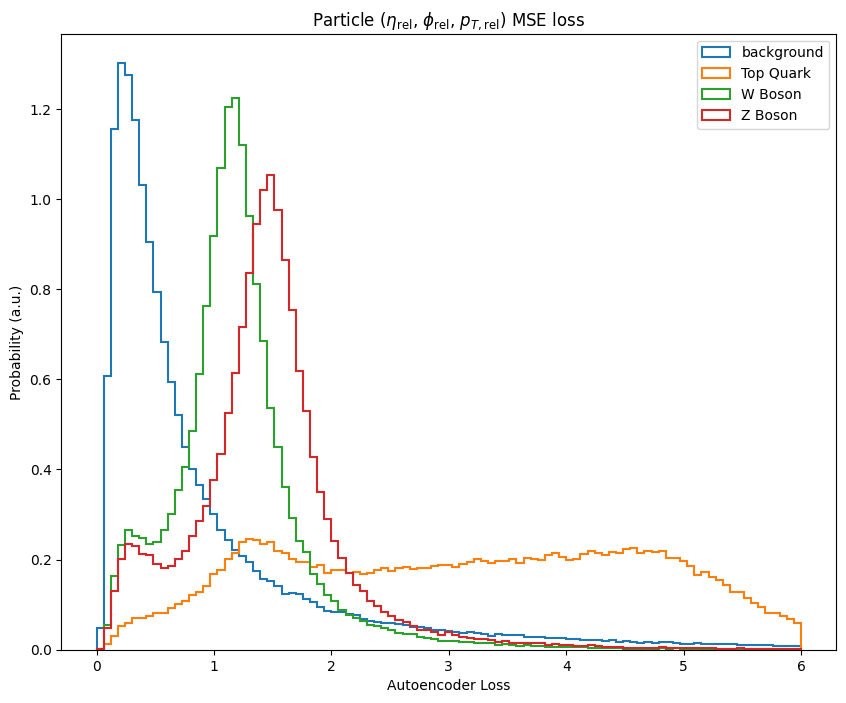

In [36]:
plot_histogram(bkg_losses, [t_signal_losses, w_signal_losses, z_signal_losses], ['Top Quark', 'W Boson', 'Z Boson'], bin_size = np.linspace(0, 6, 100))

# Plot All

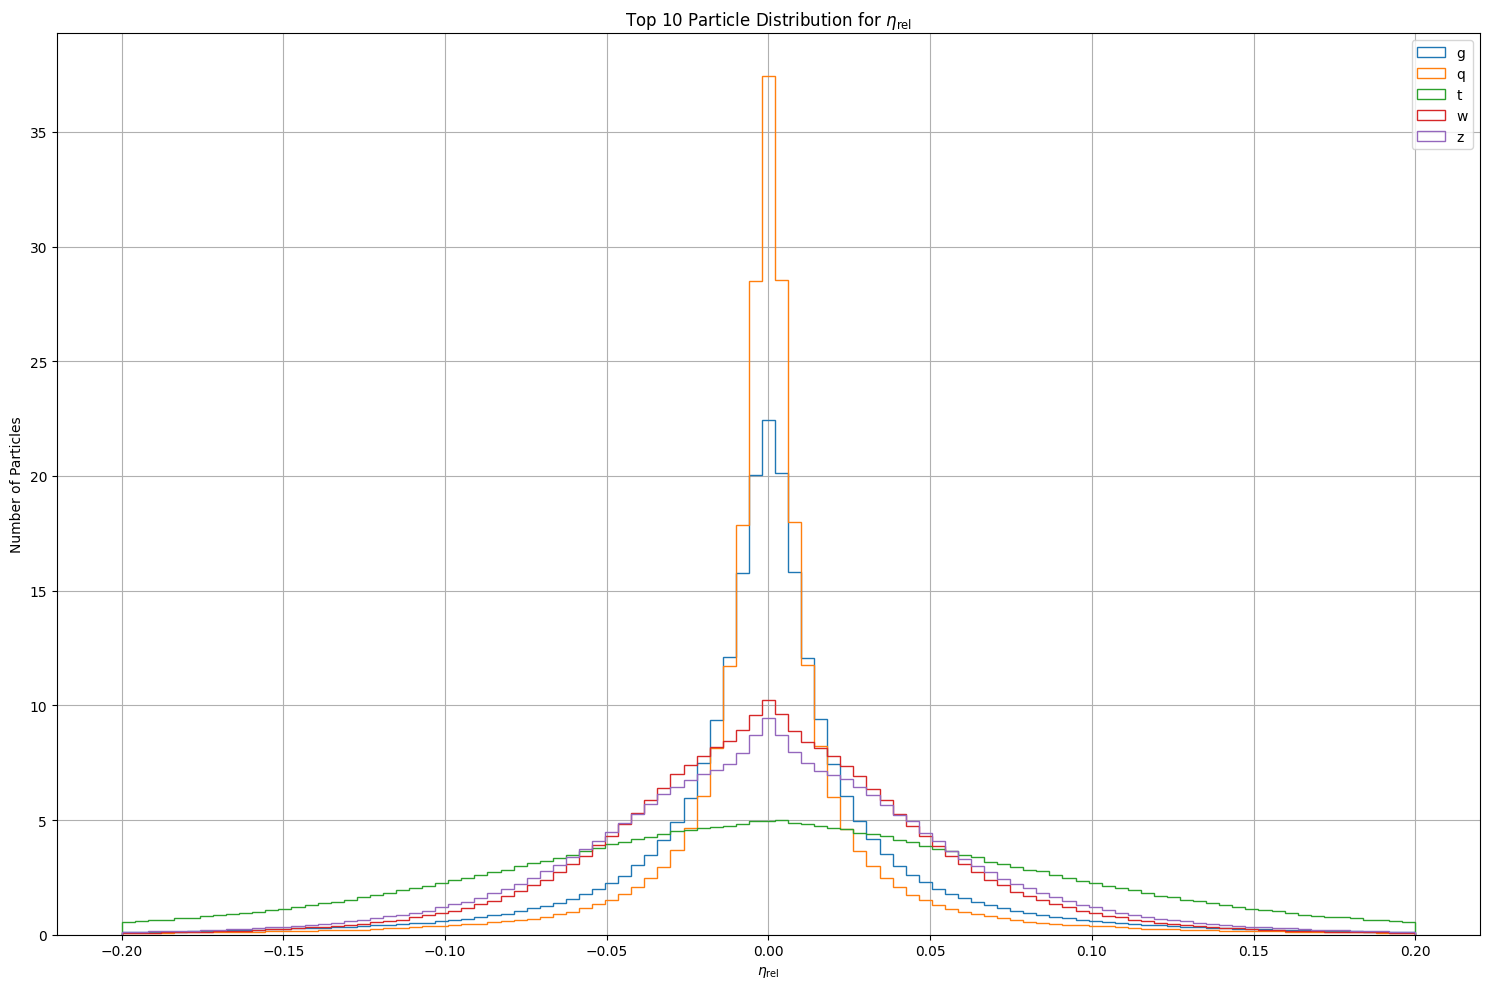

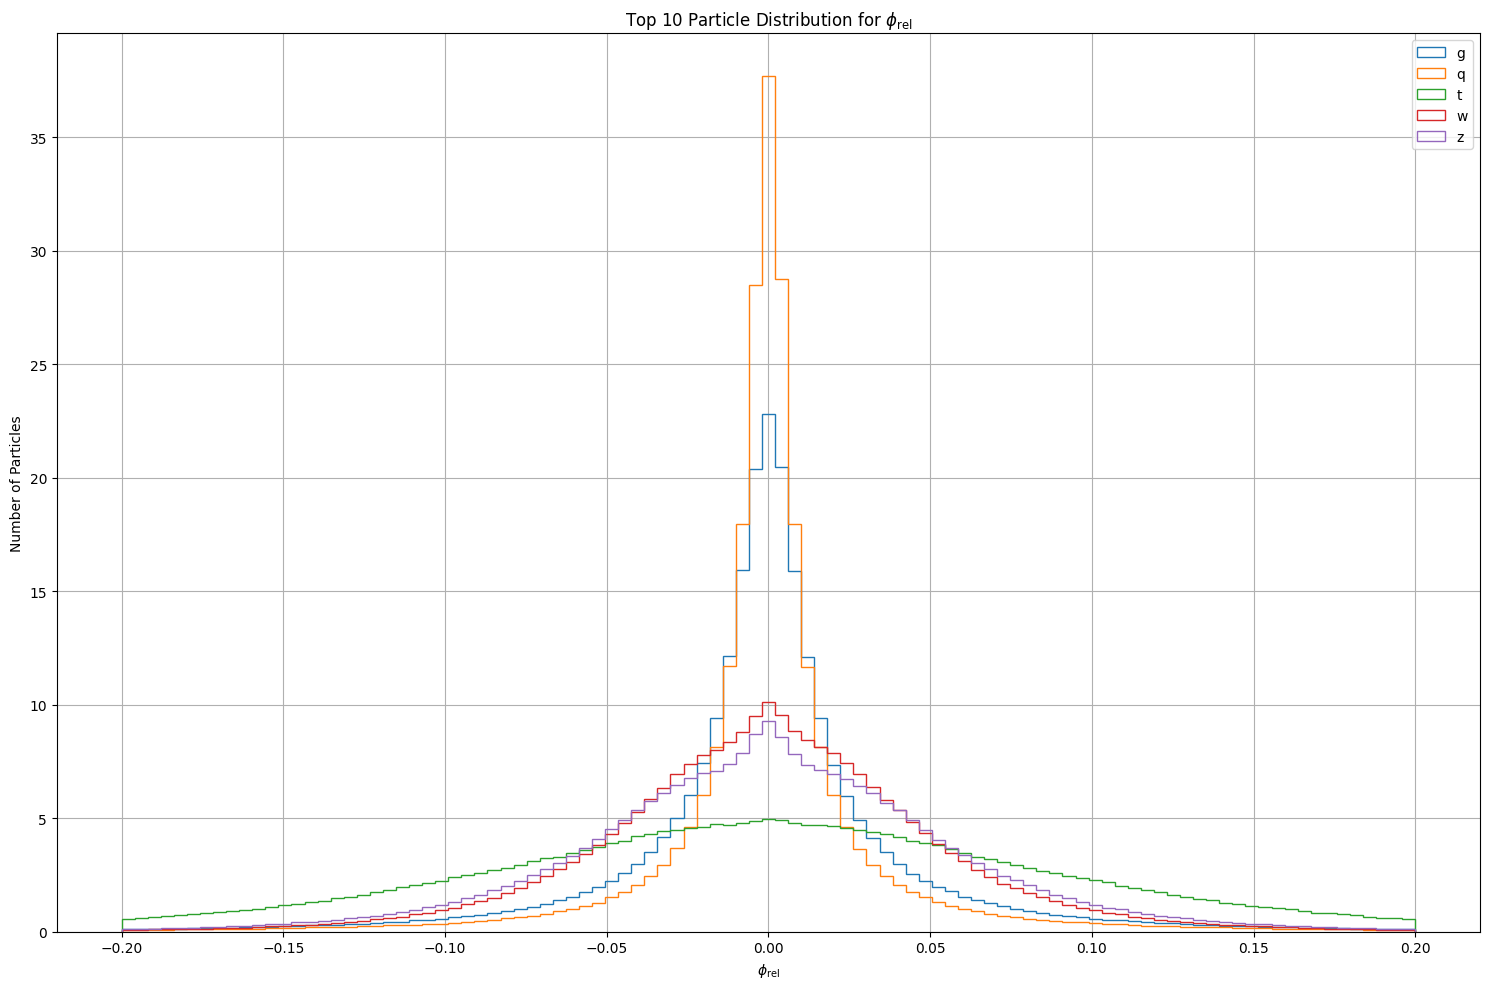

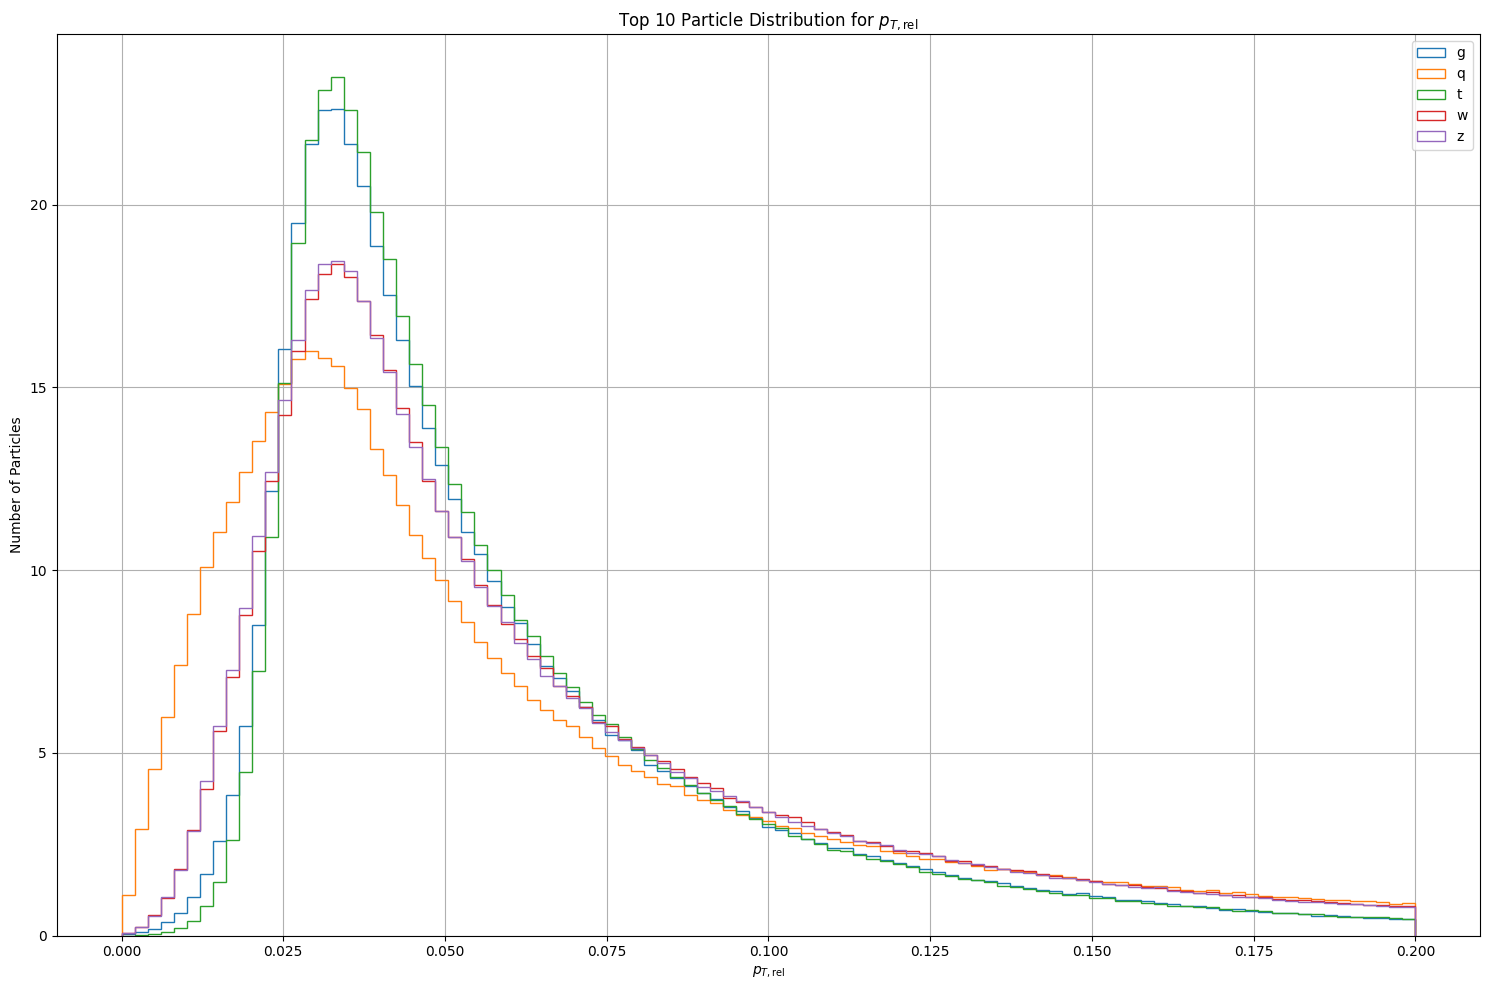

In [31]:
def load_particle_features(filepath):
    with h5py.File(filepath, 'r') as f:
        return np.array(f['particle_features'])

def select_top_particles(particle_data, n_particles=10):
    sorted_indices = np.argsort(particle_data[:,:,2], axis=1)[:,::-1]
    batch_size = particle_data.shape[0]
    range_indices = np.arange(batch_size)[:,np.newaxis]
    top_particle_data = particle_data[range_indices, sorted_indices[:,:n_particles]]
    return top_particle_data

path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'
files = {
    'g': 'g.hdf5',
    'q': 'q.hdf5',
    't': 't.hdf5',
    'w': 'w.hdf5',
    'z': 'z.hdf5'
}

features = {
    r"$\eta_{\mathrm{rel}}$": 0,
    r"$\phi_{\mathrm{rel}}$": 1,
    r"$p_{T,\mathrm{rel}}$": 2
}

for feature_label, idx in features.items():
    plt.figure(figsize=(15, 10))

    for jet_type, filename in files.items():
        particle_features = load_particle_features(path + filename)
        top_particles = select_top_particles(particle_features) # Still select based on pT

        # Extract feature values for top particles
        top_particle_feature_values = top_particles[:,:,idx].flatten()

        # Plot histogram. Adjust bins and range based on the feature.
        if idx == 2:  # pT
            plt.hist(top_particle_feature_values, bins=np.linspace(0, 0.2, 100), histtype="step", label=jet_type, density=True)
        else:  # for "eta" and "phi"
            plt.hist(top_particle_feature_values, bins=np.linspace(-0.2, 0.2, 100), histtype="step", label=jet_type, density=True)

    plt.xlabel(feature_label)
    plt.ylabel('Number of Particles')
    plt.legend()
    plt.title(f'Top 10 Particle Distribution for {feature_label}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

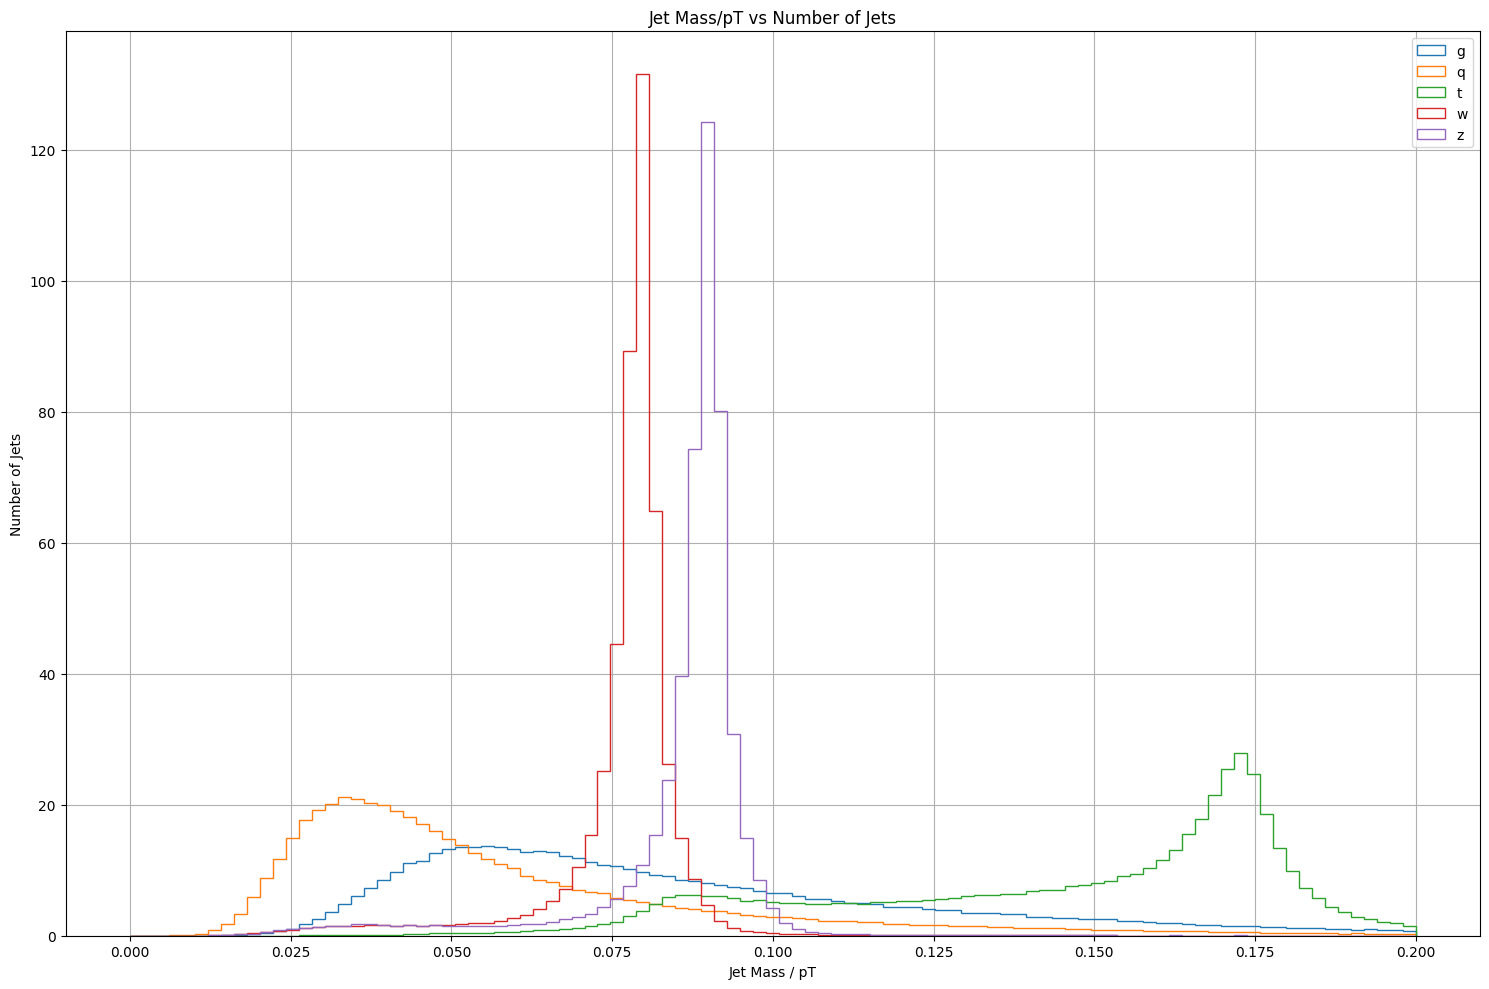

In [ ]:
def load_jet_features(filepath):
    with h5py.File(filepath, 'r') as f:
        return np.array(f['jet_features'])

path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'
files = {
    'g': 'g.hdf5',
    'q': 'q.hdf5',
    't': 't.hdf5',
    'w': 'w.hdf5',
    'z': 'z.hdf5'
}

plt.figure(figsize=(15,10))

for jet_type, filename in files.items():
    jet_features = load_jet_features(path + filename)

    # Compute jet mass / pT
    ratio = jet_features[:,2] / jet_features[:,0]
    #pt = jet_features[:,0]

    # Plot histogram
    plt.hist(ratio, bins=np.linspace(0,0.2,100), histtype="step", label=jet_type, density=True)

plt.xlabel('Jet Mass / pT')
plt.ylabel('Number of Jets')
plt.legend()
plt.title('Jet Mass/pT vs Number of Jets')
plt.grid(True)
plt.tight_layout()
plt.show()

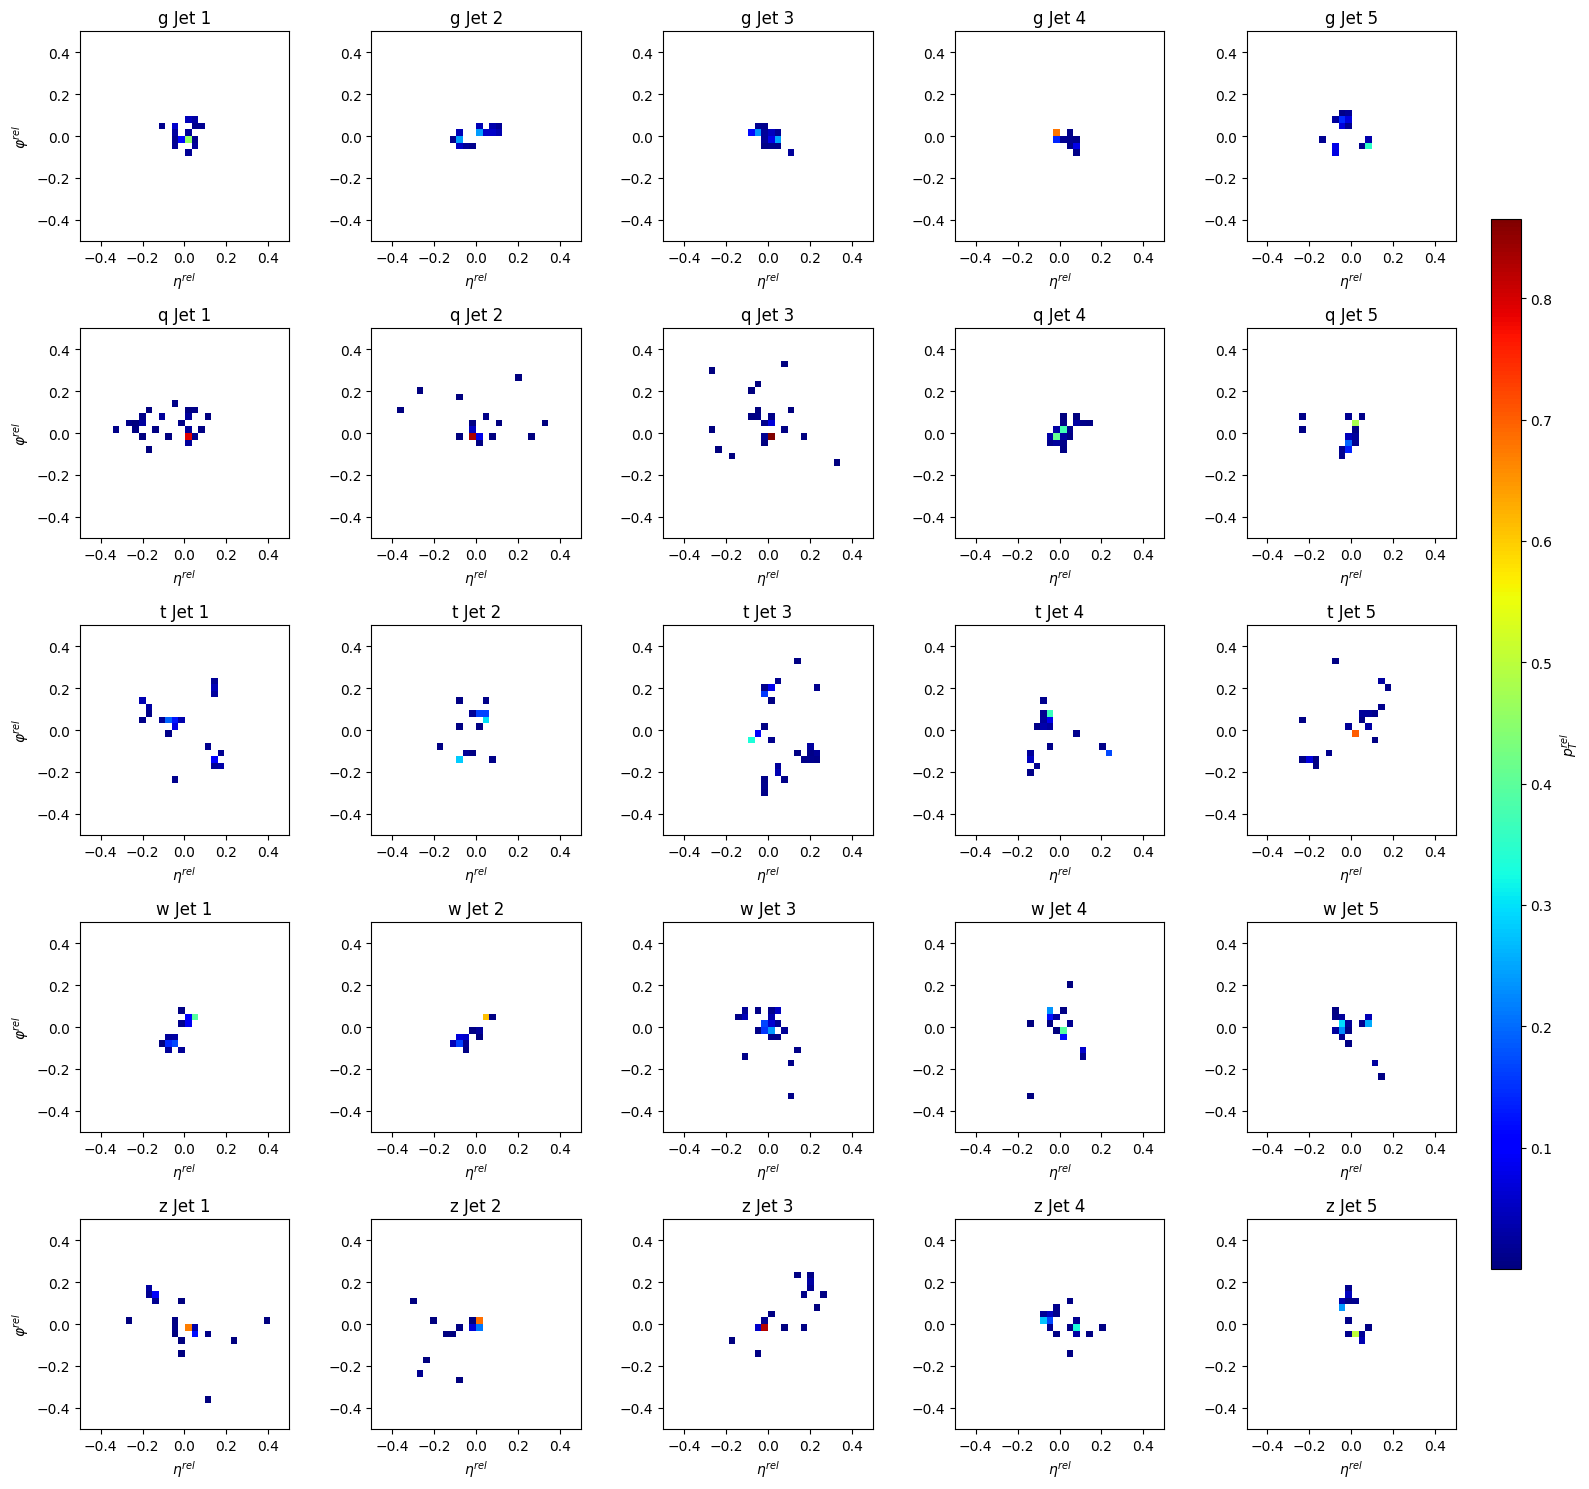

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'
files = {
    'g': 'g.hdf5',
    'q': 'q.hdf5',
    't': 't.hdf5',
    'w': 'w.hdf5',
    'z': 'z.hdf5'
}

def load_particle_features(filepath):
    with h5py.File(filepath, 'r') as f:
        return np.array(f['particle_features'])

def jet_to_image(particles_of_one_jet, bins=32, range_vals=[[-0.5, 0.5], [-0.5, 0.5]]):
    # Assuming particles_of_one_jet is of shape [30, 4]

    # Filter out masked particles
    valid_particles = particles_of_one_jet[particles_of_one_jet[:, 3] == 1]

    # Use η and φ as coordinates and pT as weights
    eta = valid_particles[:, 0]
    phi = valid_particles[:, 1]
    weights = valid_particles[:, 2]  # Using pT as weights

    # Create a 2D histogram with a specified range
    histo, xedges, yedges = np.histogram2d(eta, phi, bins=bins, weights=weights, range=range_vals)

    return histo

# Visualization
num_jets_per_type = 5
jet_types = list(files.keys())

cm = plt.cm.jet.copy()
cm.set_under(color="white")

fig, axs = plt.subplots(len(jet_types), num_jets_per_type, figsize=(15, 15))

max_val = 0
for j, jet_type in enumerate(jet_types):
    particle_features_for_all_jets = load_particle_features(path + files[jet_type])
    for i in range(num_jets_per_type):
        image = jet_to_image(particle_features_for_all_jets[i])
        if image.max() > max_val:
            max_val = image.max()

for j, jet_type in enumerate(jet_types):
    particle_features_for_all_jets = load_particle_features(path + files[jet_type])
    for i in range(num_jets_per_type):
        image = jet_to_image(particle_features_for_all_jets[i])
        ax = axs[j][i]

        # Plot the image on the subplot
        im_display = ax.imshow(image, origin='lower', extent=[-0.5, 0.5, -0.5, 0.5],
                               cmap=cm, interpolation="nearest", vmin=1e-8, vmax=max_val)

        # Set subplot title and labels
        ax.set_title(f"{jet_type} Jet {i+1}")
        ax.set_xlabel("$η^{rel}$")
        if i == 0:
            ax.set_ylabel("$φ^{rel}$")

# Adjust layout for better visualization and add a colorbar
fig.tight_layout()
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])  # position of the colorbar (left, bottom, width, height)
fig.colorbar(im_display, cax=cbar_ax, label="$p_T^{rel}$")

plt.show()